
- Repeat for different actions - e.i. changing percent to sell or buy all
- Train MC and SARSA 
    - Compare which one performs better in training
    - Compare which one performs better on Test time period


- Try negative rewards
    - Repeat for different actions - e.i. changing percent to sell or buy all
    - Train MC and SARSA 
        - Compare which one performs better in training
        - Compare which one performs better on Test time period

- Plot percent of state space experienced
- Plot actions that resulted in Gain - may only be relevant for 100%  buy sell version




### NO SOFTMAX IN ENV

In [19]:


import pandas as pd
import numpy as np
import gym
from typing import Callable, Tuple
from collections import defaultdict
from tqdm import trange
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from environments.portfolio_without_softmax import StockPortfolioEnv
import os
from agents.single_stock_tabular import sarsa_single_stock, on_policy_mc_control_single_stock

if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

print(config_tickers.DOW_30_TICKER)
#dp = YahooFinanceProcessor()
#df = dp.download_data


['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [2]:

df = YahooDownloader(start_date='2008-01-01',
                     end_date='2021-10-31',
                     ticker_list=config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [3]:
fe = FeatureEngineer(
    use_technical_indicator=True,
    use_turbulence=False,
    user_defined_feature=False)

df = fe.preprocess_data(df)

Successfully added technical indicators


In [4]:
## Add covariance matrix as states
# add covariance matrix as states
df = df.sort_values(['date', 'tic'], ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback = 252
for i in range(lookback, len(df.index.unique())):
    data_lookback = df.loc[i - lookback:i, :]
    price_lookback = data_lookback.pivot_table(index='date', columns='tic', values='close')
    return_lookback = price_lookback.pct_change().dropna()
    return_list.append(return_lookback)

    covs = return_lookback.cov().values
    cov_list.append(covs)

df_cov = pd.DataFrame({'date': df.date.unique()[lookback:], 'cov_list': cov_list, 'return_list': return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date', 'tic']).reset_index(drop=True)

df.shape
df.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2008-12-31,3.070357,3.133571,3.047857,2.583910,607541200,AAPL,2,-0.082603,3.093652,2.454292,42.254788,-80.462435,16.129793,2.749560,2.861671,"[[0.001348969202837141, 0.00042841222944239984...",tic AAPL AMGN AXP ...
1,2008-12-31,57.110001,58.220001,57.060001,41.839516,6287200,AMGN,2,0.156756,42.707030,40.853190,51.060607,51.523316,10.432018,41.058032,40.603774,"[[0.001348969202837141, 0.00042841222944239984...",tic AAPL AMGN AXP ...
2,2008-12-31,17.969999,18.750000,17.910000,14.580751,9625600,AXP,2,-0.935583,18.646872,12.660474,42.554841,-75.437645,25.776759,15.744065,17.616375,"[[0.001348969202837141, 0.00042841222944239984...",tic AAPL AMGN AXP ...
3,2008-12-31,41.590000,43.049999,41.500000,32.005878,5443100,BA,2,-0.279800,32.174380,28.867828,47.440230,156.994618,5.366299,30.327210,32.389913,"[[0.001348969202837141, 0.00042841222944239984...",tic AAPL AMGN AXP ...
4,2008-12-31,43.700001,45.099998,43.700001,29.608654,6277400,CAT,2,0.655611,30.348088,25.455649,51.205307,98.374149,26.331746,26.689551,26.423592,"[[0.001348969202837141, 0.00042841222944239984...",tic AAPL AMGN AXP ...


In [5]:
TRAIN_START = '2009-01-01'
TRAIN_END ='2020-07-01'
TEST_START = '2020-07-01'
TEST_END = '2021-10-31'

train = data_split(df, TRAIN_START, TRAIN_END)
trade = data_split(df,TEST_START, TEST_END)

In [6]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}


Stock Dimension: 28, State Space: 28


In [7]:
EPISODES = 10

In [8]:
sarsa_env = StockPortfolioEnv(df = train, **env_kwargs)

In [9]:
sarsa_post_training_env, sarsa_training_episodes, sarsa_Q = sarsa_single_stock(sarsa_env, num_episodes=EPISODES, gamma=0.99, epsilon=0.1, step_size=0.5, stock=0, aggressive=True)

Episode:  10%|█         | 1/10 [00:06<00:55,  6.12s/it]

begin_total_asset:1000000
end_total_asset:6513057.528064535
Sharpe:  0.9317561766329409


Episode:  20%|██        | 2/10 [00:11<00:46,  5.82s/it]

begin_total_asset:1000000
end_total_asset:3153087.72973465
Sharpe:  0.6175968545272433


Episode:  30%|███       | 3/10 [00:17<00:39,  5.69s/it]

begin_total_asset:1000000
end_total_asset:2722943.103501663
Sharpe:  0.5465243372089036


Episode:  40%|████      | 4/10 [00:22<00:33,  5.62s/it]

begin_total_asset:1000000
end_total_asset:4660969.678319617
Sharpe:  0.7868102271409735


Episode:  50%|█████     | 5/10 [00:28<00:28,  5.60s/it]

begin_total_asset:1000000
end_total_asset:3079113.895822329
Sharpe:  0.6017596956181217


Episode:  60%|██████    | 6/10 [00:33<00:22,  5.57s/it]

begin_total_asset:1000000
end_total_asset:4544434.698307453
Sharpe:  0.7572448517203626


Episode:  70%|███████   | 7/10 [00:39<00:16,  5.55s/it]

begin_total_asset:1000000
end_total_asset:3552870.181041544
Sharpe:  0.6436685156631999


Episode:  80%|████████  | 8/10 [00:45<00:11,  5.63s/it]

begin_total_asset:1000000
end_total_asset:5100145.081589518
Sharpe:  0.8224640493704211


Episode:  90%|█████████ | 9/10 [00:50<00:05,  5.65s/it]

begin_total_asset:1000000
end_total_asset:6830147.294754996
Sharpe:  0.9474400418630148


begin_total_asset:1000000
end_total_asset:5346429.259405458
Sharpe:  0.8518697444452353


In [10]:
sarsa_test_env = StockPortfolioEnv(df = trade, **env_kwargs)
sarsa_test_post_training_env, sarsa_test_episode, sarsa_test_Q  = sarsa_single_stock(sarsa_test_env, num_episodes=1, gamma=0.99, epsilon=0.1, step_size=0.5, stock=0, q=sarsa_Q, aggressive=True)

begin_total_asset:1000000
end_total_asset:1208973.51024148
Sharpe:  0.8367127280232164


In [11]:
# SARSA TRAINING PLOT
# episode.append((S, A, reward, percent))
sarsa_all_episode_rewards = []
for episode in sarsa_training_episodes:
    episode_rewards = []
    for step in episode:
        reward = step[2]
        episode_rewards.append(reward)
    sarsa_all_episode_rewards.append(episode_rewards)
sarsa_final_amounts = [rewards[-1] for rewards in sarsa_all_episode_rewards]

In [12]:
train_mc = StockPortfolioEnv(df = train, **env_kwargs)

In [13]:
post_mc_train_env, mc_train_episodes, mc_Q = on_policy_mc_control_single_stock(train_mc, num_episodes=EPISODES, gamma=0.99, epsilon=0.5, step_size=0.5, stock=0, aggressive=True)

Episode:   0%|          | 0/10 [00:00<?, ?it/s]

begin_total_asset:1000000
end_total_asset:5337053.154120834
Sharpe:  0.8397998180441719


Episode:  10%|█         | 1/10 [00:05<00:53,  6.00s/it]

begin_total_asset:1000000
end_total_asset:9472915.935413597
Sharpe:  1.0895669058135897


Episode:  20%|██        | 2/10 [00:11<00:47,  5.97s/it]

begin_total_asset:1000000
end_total_asset:7857130.205235918
Sharpe:  0.9868603089168879


Episode:  30%|███       | 3/10 [00:17<00:41,  5.98s/it]

begin_total_asset:1000000
end_total_asset:6290578.951104602
Sharpe:  0.9268162466274399


Episode:  40%|████      | 4/10 [00:24<00:37,  6.18s/it]

begin_total_asset:1000000
end_total_asset:5059907.345787575
Sharpe:  0.7850482599774429


Episode:  50%|█████     | 5/10 [00:30<00:31,  6.22s/it]

begin_total_asset:1000000
end_total_asset:12171472.162601314
Sharpe:  1.244731554363319


Episode:  60%|██████    | 6/10 [00:36<00:24,  6.15s/it]

begin_total_asset:1000000
end_total_asset:10679874.320336463
Sharpe:  1.168017524880784


Episode:  70%|███████   | 7/10 [00:42<00:18,  6.11s/it]

begin_total_asset:1000000
end_total_asset:6518403.544337033
Sharpe:  0.9026693940389154


Episode:  80%|████████  | 8/10 [00:48<00:12,  6.09s/it]

begin_total_asset:1000000
end_total_asset:10073082.036850465
Sharpe:  1.0905481160138097


Episode:  90%|█████████ | 9/10 [00:54<00:06,  6.11s/it]

begin_total_asset:1000000
end_total_asset:5820046.163670498
Sharpe:  0.8883176100912771


In [14]:
mc_test_env = StockPortfolioEnv(df = trade, **env_kwargs)
mc_test_env_post, mc_test_episode, mc_test_q  = on_policy_mc_control_single_stock(mc_test_env, num_episodes=1, gamma=0.99, epsilon=0.1, step_size=0.5, stock=0, q=mc_Q, aggressive=True)

begin_total_asset:1000000
end_total_asset:1824737.7663157878
Sharpe:  2.1837035568035583


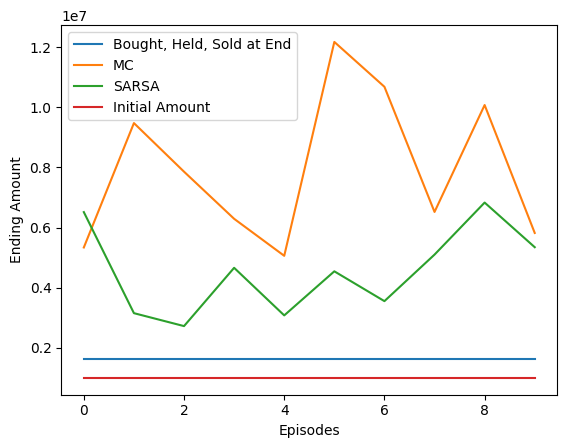

In [21]:
# MC TRAINING PLOT
mc_all_episode_rewards = []
for episode in mc_train_episodes:
    episode_rewards = []
    for step in episode:
        reward = step[2]
        episode_rewards.append(reward)
    mc_all_episode_rewards.append(episode_rewards)
        

mc_final_amounts = [rewards[-1] for rewards in mc_all_episode_rewards]

starting_value = trade[(trade['date'] == '2020-07-01') & (trade['tic'] == 'AAPL')]['open'].values[0]
stocks = 1_000_000 / starting_value

end_value =trade[(trade['date'] == '2021-10-29') & (trade['tic'] == 'AAPL')]['open'].values[0]
end_amount_if_bought_and_held = end_value * stocks

plt.plot(list(range(EPISODES)), [end_amount_if_bought_and_held] * EPISODES, label='Bought, Held, Sold at End')
plt.plot(list(range(EPISODES)), mc_final_amounts, label='MC')
plt.plot(list(range(EPISODES)), sarsa_final_amounts, label='SARSA')
plt.plot(list(range(EPISODES)), [1_000_000] * EPISODES, label='Initial Amount')
plt.xlabel('Episodes')
plt.ylabel('Ending Amount')
plt.legend()
plt.show()

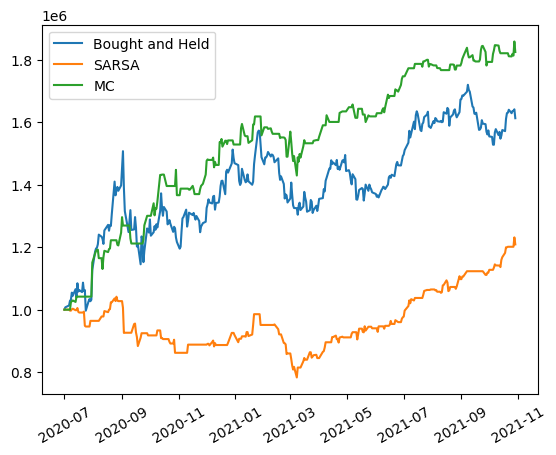

In [22]:
#PLOT COMPARING PORTFOLIO VALUE OF TEST EPISODE AGAINST JUST HOLDING STOCK WITH SARSA AND MC

starting_value = trade[(trade['date'] == '2020-07-01') & (trade['tic'] == 'AAPL')]['open'].values[0]
stocks = 1_000_000 / starting_value
values_while_held = trade[(trade['date'] >= '2020-07-01') & (trade['tic'] == 'AAPL')]['open'].to_numpy() * stocks
dates = np.asarray(trade[(trade['date'] >= '2020-07-01') & (trade['tic'] == 'AAPL')]['date'], dtype='datetime64[s]')
plt.plot(dates, values_while_held, label="Bought and Held")
sarsa_test_values = sarsa_test_env.asset_memory
plt.plot(dates, sarsa_test_values, label="SARSA")
mc_test_values = mc_test_env_post.asset_memory
plt.plot(dates, mc_test_values, label="MC")
plt.xticks(rotation=30)
plt.legend()
plt.show()


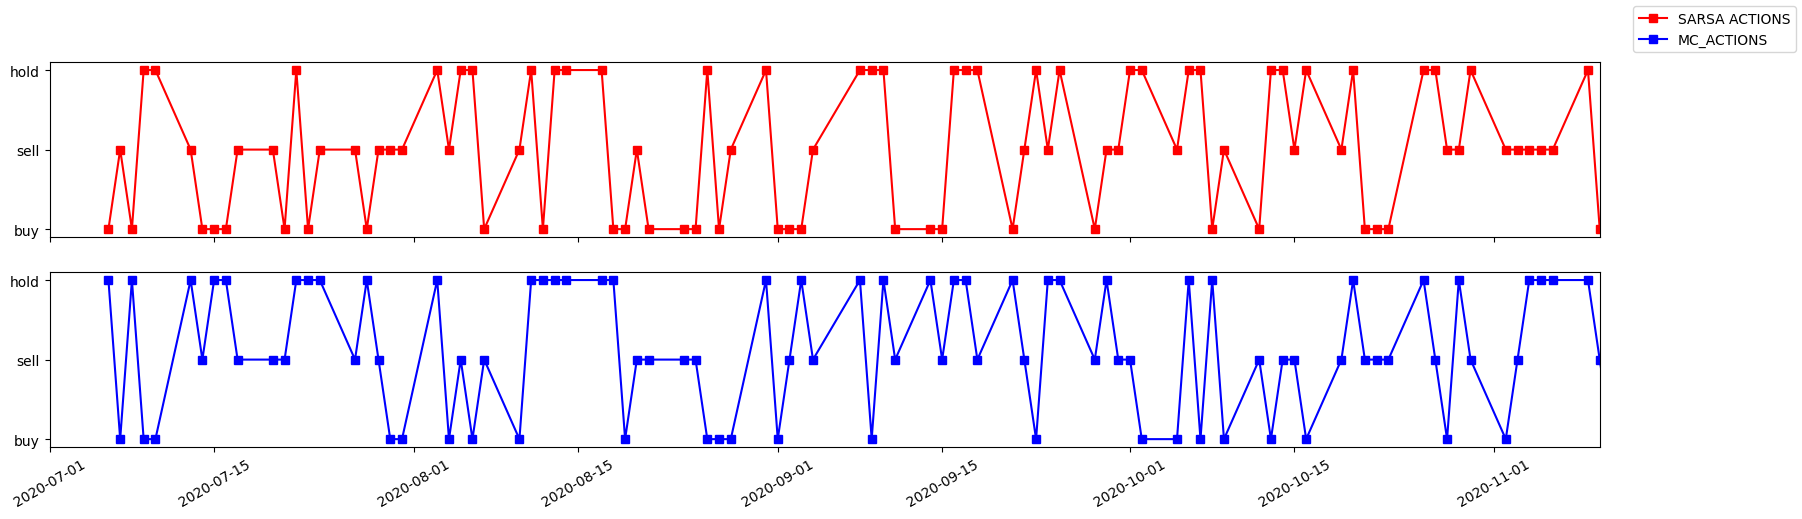

In [23]:
# ACTIONS OVER TEST
sarsa_test_actions = []
mc_test_actions = []
# episode.append((S, A, reward, percent))
action_dates = dates[2:] # account for skipping first two steps to create differences
for step in sarsa_test_episode[0]:
    action = step[1]
    sarsa_test_actions.append(action)
for step in mc_test_episode[0]:
    action = step[1]
    mc_test_actions.append(action)
fig, axs = plt.subplots(nrows=2, figsize=(20,5), sharex=True)
axs[0].plot(action_dates, sarsa_test_actions, marker = 's', label = 'SARSA ACTIONS', c='r')
axs[1].plot(action_dates, mc_test_actions, marker = 's', label= 'MC_ACTIONS', c='b')
fig.legend()
plt.xticks(rotation=30)
for ax in axs:
    ax.set_xlim(np.asarray(['2020-07-01', '2020-11-10'],  dtype='datetime64[s]'))
    ax.set_yticks([0, 1, 2]) # buy hold sell
    ax.set_yticklabels(['buy', 'sell', 'hold'])



In [18]:
# LENGTH OF EPISODES and Q TABLE SIZE PLOT